<a href="https://colab.research.google.com/github/KeyvanSadri/Getting-and-Cleaning-Data/blob/master/Process_Mining_Showcase_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from datetime import datetime, timedelta
import math
from scipy.stats import norm

from google.colab import files

# set seed
np.random.seed(42)

sample_size = 120000
start=datetime.now()

In [3]:
# set the unique ID
unique_ID = np.arange(sample_size)
unique_ID.shape

(120000,)

In [0]:
# assign Abteilung
abt = np.random.randint(5, size=(sample_size))
np.unique(abt,return_counts=True)
abt_name = np.empty([sample_size],dtype='S7')
abt_name[abt==0]='RK1_Fra'
abt_name[abt==1]='RK2_Fra'
abt_name[abt==2]='RK3_Fra'
abt_name[abt==3]='RK4_Ber'
abt_name[abt==4]='RK5_Ber'

In [0]:
# assign Filiale
# if the abteilung is 3 or 4 the Filiale must be Berlin
# Otherwise it can be Hamburg, Muenchen, Frankfurt, or Koeln
fil = np.random.randint(3,size=(sample_size))
fil_name = np.chararray(sample_size,itemsize=9,unicode=True)
fil_name[np.logical_and(fil==0,np.logical_or(abt!=3,abt!=4))]='Hamburg'
fil_name[np.logical_and(fil==1,np.logical_or(abt!=3,abt!=4))]='München'
fil_name[np.logical_and(fil==2,np.logical_or(abt!=3,abt!=4))]='Frankfurt'
fil_name[np.logical_and(fil==3,np.logical_or(abt!=3,abt!=4))]='Köln'
fil_name[np.logical_or(abt==3,abt==4)]='Berlin'

In [0]:
# set the timestamp of the creation of Antrag
# 1-6 January and 21-31 December are excluded
# Weekends are excluded
# Holidays are not excluded

# set the month and population of the month
month = np.arange(12)
weights = [0.5, 0.4, 0.9, 1.2, 2.3, 0.8, 0.4, 0.6,1.1,0.55,1.8,2.2]
credit_month = random.choices(month, weights=weights, k=sample_size)
credit_month = np.asarray(credit_month)+1

# Generate a day for the corresponding month

def day_generator(month):
  if (month in [3,5,7,8,10]):
    day = np.random.randint(31)+1
  elif (month in [4,6,9,11]):
    day = np.random.randint(30)+1
  elif (month ==2):
    day = np.random.randint(28)+1
  elif (month==12):
    day = np.random.randint(21)+1
  else:
    day = np.random.randint(7,31)+1
  return day

my_day = np.array([day_generator(month) for month in credit_month])

# Generate hour between 9 and 17
hour = np.random.randint(8,size=(sample_size))+9

#Generate minute between 0 and 60
minute = np.random.randint(59,size=(sample_size))

# column bind the year (always 2018), month, day, hour, and minute 
dt_matrix = np.concatenate([np.full((sample_size, 1), 2018),credit_month.reshape(sample_size,1),my_day.reshape(sample_size,1),hour.reshape(sample_size,1),minute.reshape(sample_size,1)],axis=1)

#convert each row to a datetime object
initial_timestamp = [datetime(*x) for x in dt_matrix]

# drop the weekends from the timestamp
def weekenddrop(dt):
  if dt.day in [5,6]:
    dt.replace(day=dt.day+random.randint(0,5))
  return dt

initial_timestamp = np.array([weekenddrop(dt) for dt in initial_timestamp])

In [0]:
# Generate the distribution of Wunschkredithöhe
wkh = sample_size/3

# min max scaler function
def range_scaler(my_array):
  my_array = (my_array - my_array.min())/(my_array.max()-my_array.min())
  return my_array

# round up to thousend
def thoused_round(x):
  x=math.ceil(x / 500.0) * 500.0
  return x

# Weibull (Negatively skewed)
weibull_case = np.random.weibull(5,40000)
weibull_case = range_scaler(weibull_case)

# Gamma (Positively skewed)
shape, scale = 3., 1. # mean and width
gamma_case = np.random.standard_gamma(shape, 40000)
gamma_case = range_scaler(gamma_case)

# Von Mises (not skewed)
vonmises_case = np.random.vonmises(1,5,40000)
vonmises_case = range_scaler(vonmises_case)

# row bind the distributions for Wuschkredithöhe 
wkh_vector = np.concatenate([weibull_case.reshape(40000,1),gamma_case.reshape(40000,1),vonmises_case.reshape(40000,1)],axis=0)
wkh_vector = wkh_vector*79000 + 1000

# round up the amounts to upper 1000
wkh_vector = np.array([thoused_round(x) for x in wkh_vector])

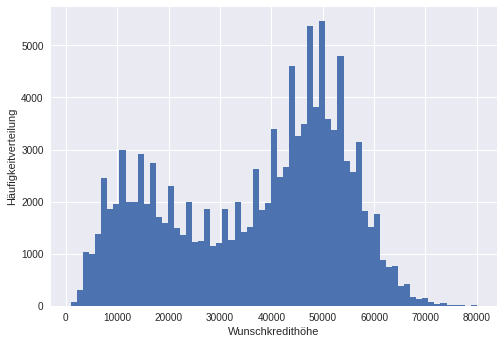

In [8]:
plt.hist(wkh_vector, bins='auto')
plt.xlabel('Wunschkredithöhe')
plt.ylabel('Häufigkeitverteilung')
plt.show()
#plt.savefig('Wuschhohe_Histogram.png')
#files.download('Wuschhohe_Histogram.png')

In [0]:
# Randomly generate the Laufzeit and applying the constraints

# Weibull (Negatively skewed)
laufzeit = np.random.weibull(5,sample_size)
laufzeit = range_scaler(laufzeit)
laufzeit = laufzeit*54+6
laufzeit = laufzeit.astype(int)

In [10]:
# combine the Wunschkredithöhe and Laufzeit
hoehe_laufzeit_rate = np.concatenate([wkh_vector.reshape(sample_size,1),laufzeit.reshape(sample_size,1)],axis=1)

rate = hoehe_laufzeit_rate[:,0]*0.67/hoehe_laufzeit_rate[:,1]
hoehe_laufzeit_rate = np.concatenate([hoehe_laufzeit_rate,rate.reshape(sample_size,1)],axis=1)
hoehe_laufzeit_rate.shape

(120000, 3)

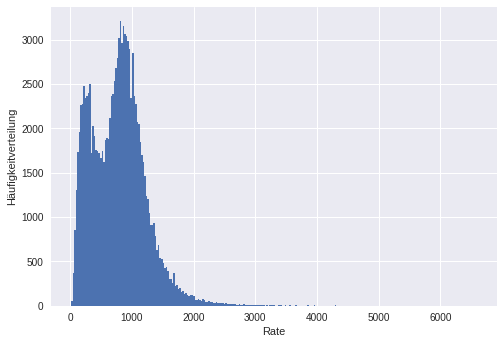

In [11]:
# Plot the Rate
plt.hist(rate, bins='auto')
plt.xlabel('Rate')
plt.ylabel('Häufigkeitverteilung')
plt.show() 
#plt.savefig('Rate_Histogram.png')
#files.download('Rate_Histogram.png')

In [0]:
d = {'kredit_id': unique_ID.reshape(sample_size),
     'timestamp':initial_timestamp.reshape(sample_size),
     'activity': np.full((sample_size), 'kreditantrag_erstellen'),
     'Region':fil_name.reshape(sample_size),
     'wunschkredithoehe':hoehe_laufzeit_rate[:,0].reshape(sample_size),
     'rate':hoehe_laufzeit_rate[:,2].reshape(sample_size),
     'laufzeit':hoehe_laufzeit_rate[:,1].reshape(sample_size)
    }
df_start = pd.DataFrame(data=d,index=np.arange(sample_size))

In [13]:
df_start["tatsächliche_kredithöhe"] = np.nan
df_start["Schufascore"] = np.nan
df_start["Ratingklasse"] = np.nan
df_start["loop"] = 0

# randomly select 50% of the instances and set the mitarbeiter to 'Robo', the rest to 'otto' reprensenting a human agent
df_start["mitarbeiter"]=np.nan
robo_index = df_start.sample(frac=0.1).index
df_start.loc[robo_index,'mitarbeiter'] = 'robo'
df_start.mitarbeiter[(df_start.mitarbeiter.isna())] = 'otto'

df_start.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


,Region,activity,kredit_id,laufzeit,rate,timestamp,wunschkredithoehe,tatsächliche_kredithöhe,Schufascore,Ratingklasse,loop,mitarbeiter
0,Berlin,kreditantrag_erstellen,0,38.0,1057.894737,2018-08-31 13:01:00,60000.0,NaN,NaN,NaN,0,otto
1,Berlin,kreditantrag_erstellen,1,35.0,679.571429,2018-01-19 09:02:00,35500.0,NaN,NaN,NaN,0,otto
2,Frankfurt,kreditantrag_erstellen,2,40.0,778.875000,2018-04-08 14:17:00,46500.0,NaN,NaN,NaN,0,otto
3,Berlin,kreditantrag_erstellen,3,31.0,432.258065,2018-09-10 12:50:00,20000.0,NaN,NaN,NaN,0,otto
4,Berlin,kreditantrag_erstellen,4,28.0,741.785714,2018-06-12 10:30:00,31000.0,NaN,NaN,NaN,0,otto


In [0]:
# add minutes to timestamp
def minute_editor(timestamp,minute):
  timestamp = timestamp + timedelta(seconds=minute*60)
  if (timestamp.hour>17):
    timestamp = timestamp + timedelta(hours=16)
  if (timestamp.weekday()==5):
    timestamp = timestamp + timedelta(days=2)
  elif (timestamp.weekday()==6):
    timestamp = timestamp + timedelta(days=1)
  return timestamp

# add days to timestamp
def day_editor(timestamp,day):
  timestamp = timestamp + timedelta(days=day)
  if (timestamp.weekday()==5):
    timestamp = timestamp + timedelta(days=2)
  elif (timestamp.weekday()==6):
    timestamp = timestamp + timedelta(days=1)
  return timestamp

In [0]:
def progress_propagator(df_in,status,time_difference,time_unit,frac,automation_portion):
  # Throw an exception if the input vectors have different number of values
  if(len(status)!=len(time_difference) or len(status)!=len(time_difference) or len(status)!=len(time_unit) or len(status)!=len(frac) or len(status)!=len(automation_portion)):
    raise ValueError("Lengths of Status, Time Difference, Fraction, and Automation Portion are not equal.")
    
  # normalize the fraction and get the number of rows for the output dataframes for each status
  frac = frac/np.sum(frac)
  frac_count = df_in.shape[0]*frac
  frac_count = frac_count.astype(int)
  if (np.sum(frac_count)>df_in.shape[0]):
    frac_count[len(frac_count)] = frac_count[len(frac_count)]-np.sum(frac_count)+df_in.shape[0]
  
  df_res = df_in.copy()
  df_out = pd.DataFrame(columns=df_in.columns)
  for i in range(0,len(status)):
    df_update = df_res.sample(n=frac_count[i])
    df_res = df_res.drop(df_update.index)
    df_update = df_update.reset_index(drop=True)
    df_res = df_res.reset_index(drop=True)
    
    # update the timestamp of the df_update
    if(time_unit[i]=='mins'):
      df_update['timestamp'] = df_update['timestamp'].apply(minute_editor,minute=time_difference[i])
    elif(time_unit[i]=='days'):
      df_update['timestamp'] = df_update['timestamp'].apply(day_editor,day=time_difference[i])
    else:
      raise ValueError("Unit of time can be mins or days")
      
    # update the status of the df_update
    df_update['activity'] = status[i]
    
    # set the mitarbeiter of df_update
    df_update['mitarbeiter'] = np.nan
    robo_index = df_update.sample(frac=automation_portion[i]).index
    df_update.loc[robo_index,'mitarbeiter'] = 'robo'
    df_update.mitarbeiter[(df_update.mitarbeiter.isna())] = 'otto'
    df_out = df_out.append(df_update)
  df_out=df_out.reset_index(drop=True)
  return(df_out)

In [16]:
# Generate the next step from Kreditantrag_erstellen_und_einreichen
status = ['Kreditanträge_verteilen','Unterlagen_auf_Vollständigkeit_Prüfen']
td = [3,2]
td_unit = ['days','days']
frac = [0.1,0.9]
automation_portion = [0.4,0.5]
df_erstellen = progress_propagator(df_start,status=status,time_difference=td,time_unit=td_unit,frac=frac,automation_portion=automation_portion)
df_erstellen = df_start.append(df_erstellen)
print(df_erstellen.head())
print(df_erstellen.tail())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


      Region                activity kredit_id  laufzeit         rate  \
0     Berlin  kreditantrag_erstellen         0      38.0  1057.894737   
1     Berlin  kreditantrag_erstellen         1      35.0   679.571429   
2  Frankfurt  kreditantrag_erstellen         2      40.0   778.875000   
3     Berlin  kreditantrag_erstellen         3      31.0   432.258065   
4     Berlin  kreditantrag_erstellen         4      28.0   741.785714   

            timestamp  wunschkredithoehe  tatsächliche_kredithöhe  \
0 2018-08-31 13:01:00            60000.0                      NaN   
1 2018-01-19 09:02:00            35500.0                      NaN   
2 2018-04-08 14:17:00            46500.0                      NaN   
3 2018-09-10 12:50:00            20000.0                      NaN   
4 2018-06-12 10:30:00            31000.0                      NaN   

   Schufascore  Ratingklasse loop mitarbeiter  
0          NaN           NaN    0        otto  
1          NaN           NaN    0        otto  
2 

In [17]:
# from Kreditanträge verteilen to Unterlagen auf Vollständigkeit Prüfen
df_kreditantraege_verteilen = df_erstellen[(df_erstellen['activity']=='Kreditanträge_verteilen')]
status = ['Unterlagen_auf_Vollständigkeit_Prüfen']
td = [2]
td_unit = ['days']
frac = [1.0]
automation_portion = [0.5]
df_erstellen_2 = progress_propagator(df_kreditantraege_verteilen,status=status,time_difference=td,time_unit=td_unit,frac=frac,automation_portion=automation_portion)
df_erstellen_2 = df_erstellen.append(df_erstellen_2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [18]:
# from Unterlagen auf Vollständigkeit Prüfen to Kreditantrag prüfen
df_unterlagen_auf_vollstaendigkeit_pruefen = df_erstellen_2[(df_erstellen_2['activity']=='Unterlagen_auf_Vollständigkeit_Prüfen') & (df_erstellen_2['loop']==0)]
status = ['Kreditantrag_prüfen','Unterlagen_nachfordern']
td = [2,5]
td_unit = ['mins','mins']
frac=[0.9,0.1]
automation_portion = [0.0,0.0]
df_unterlagen_auf_vollstaendigkeit_pruefen = progress_propagator(df_unterlagen_auf_vollstaendigkeit_pruefen,status=status,time_difference=td,time_unit=td_unit,frac=frac,automation_portion=automation_portion)
df_unterlagen_auf_vollstaendigkeit_pruefen.loop.loc[(df_unterlagen_auf_vollstaendigkeit_pruefen['activity']=='Unterlagen_nachfordern')] = 1
df_unterlagen_auf_vollstaendigkeit_pruefen = df_erstellen_2.append(df_unterlagen_auf_vollstaendigkeit_pruefen)
df_unterlagen_auf_vollstaendigkeit_pruefen = df_unterlagen_auf_vollstaendigkeit_pruefen.reset_index(drop=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [19]:
# from Unterlagen nachfordern to Unterlagen auf Vollständigkeit Prüfen
df_unterlagen_nachfordern = df_unterlagen_auf_vollstaendigkeit_pruefen[(df_unterlagen_auf_vollstaendigkeit_pruefen['activity']=='Unterlagen_nachfordern') & (df_unterlagen_auf_vollstaendigkeit_pruefen['loop']==1)]
status = ['Unterlagen_auf_Vollständigkeit_Prüfen']
td = [2]
td_unit = ['days']
frac=[1.0]
automation_portion=[1.0]
df_unterlagen_nachfordern = progress_propagator(df_unterlagen_nachfordern,status=status,time_difference=td,time_unit=td_unit,frac=frac,automation_portion=automation_portion)
df_unterlagen_auf_vollstaendigkeit_pruefen = df_unterlagen_auf_vollstaendigkeit_pruefen.append(df_unterlagen_nachfordern)
df_unterlagen_auf_vollstaendigkeit_pruefen = df_unterlagen_auf_vollstaendigkeit_pruefen.reset_index(drop=True)

# from Unterlagen auf Vollständigkeit Prüfen to Kreditantrag Prüfen
status = ['Kreditantrag_prüfen']
td = [2]
td_unit = ['mins']
frac=[1.0]
automation_portion=[1.0]
df_unterlagen_nachfordern = progress_propagator(df_unterlagen_nachfordern,status=status,time_difference=td,time_unit=td_unit,frac=frac,automation_portion=automation_portion)
df_unterlagen_nachfordern['loop']=0
df_unterlagen_nachfordern.head()
df_unterlagen_auf_vollstaendigkeit_pruefen = df_unterlagen_auf_vollstaendigkeit_pruefen.append(df_unterlagen_nachfordern)
df_unterlagen_auf_vollstaendigkeit_pruefen = df_unterlagen_auf_vollstaendigkeit_pruefen.reset_index(drop=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [20]:
# from Kreditantrag_prüfen to Angaben_korrigieren and Bonitätsprüfung_durchführen
df_bonitaetpruefung = df_unterlagen_auf_vollstaendigkeit_pruefen[(df_unterlagen_auf_vollstaendigkeit_pruefen['activity']=='Kreditantrag_prüfen')]
status = ['Angaben_korrigieren','Bonitätsprüfung_durchführen']
td = [10,2]
td_unit = ['mins','mins']
frac=[0.1,0.9]
automation_portion=[0.0,0.5]
df_bonitaetpruefung = progress_propagator(df_bonitaetpruefung,status=status,time_difference=td,time_unit=td_unit,frac=frac,automation_portion=automation_portion)
df_bonitaetpruefung = df_bonitaetpruefung.reset_index(drop=True)
df_bonitaetpruefung = df_unterlagen_auf_vollstaendigkeit_pruefen.append(df_bonitaetpruefung)
df_bonitaetpruefung = df_bonitaetpruefung.reset_index(drop=True)
#from Angaben_korrigieren to Bonitätsprüfung durchführen
df_angaben_korrigieren = df_bonitaetpruefung[(df_bonitaetpruefung['activity']=='Angaben_korrigieren')]
status = ['Bonitätsprüfung_durchführen']
td = [10]
td_unit = ['mins']
frac=[1.0]
automation_portion=[0.5]
df_angaben_korrigieren = progress_propagator(df_angaben_korrigieren,status=status,time_difference=td,time_unit=td_unit,frac=frac,automation_portion=automation_portion)
df_bonitaetpruefung = df_bonitaetpruefung.append(df_angaben_korrigieren)
df_bonitaetpruefung = df_bonitaetpruefung.reset_index(drop=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [21]:
# from Bonitätsprüfung_durchführen to Unterlagen_nachfordern_2, Zweiten_Kreditnehmer_aufnehmen, Angaben_korrigieren_2, and Schufa_abfragen
# Filter the df_bonitaetpruefung dataframe to get the rows with activity == 'Bonitätsprüfung_durchführen' and generate the dataframes of the next steps
df_bonitaetpruefung_2 = df_bonitaetpruefung[(df_bonitaetpruefung['activity']=='Bonitätsprüfung_durchführen')]
status = ['Unterlagen_nachfordern_2','zweiten_Kreditnehmer_aufnehmen','Angaben_korrigieren_2','Schufa_abfragen']
td = [5,10,2,3]
td_unit = ['mins','mins','days','mins']
frac = [0.2,0.05,0.15,0.6]
automation_portion = [0.2,0.4,0.1,0.5]
df_bonitaetpruefung_2 = progress_propagator(df_bonitaetpruefung_2,status=status,time_difference=td,time_unit=td_unit,frac=frac,automation_portion=automation_portion)
df_bonitaetpruefung_2 = df_bonitaetpruefung_2.reset_index(drop=True)
df_bonitaetpruefung_2.loop.loc[(df_bonitaetpruefung_2['activity']=='Unterlagen_nachfordern_2')] = 10
df_bonitaetpruefung_2.loop.loc[(df_bonitaetpruefung_2['activity']=='zweiten_Kreditnehmer_aufnehmen')] = 100

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [22]:
# from Angaben_korrigieren_2 to the Schufa_abfragen
df_bonitaetpruefung_3 = df_bonitaetpruefung_2[(df_bonitaetpruefung_2['activity']=='Angaben_korrigieren_2')]
status = ['Schufa_abfragen']
td = [3]
td_unit = ['days']
frac = [1.0]
automation_portion = [0.0]
df_bonitaetpruefung_3 = progress_propagator(df_bonitaetpruefung_3,status=status,time_difference=td,time_unit=td_unit,frac=frac,automation_portion=automation_portion)
df_bonitaetpruefung_3 = df_bonitaetpruefung_3.reset_index(drop=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [23]:
# from zweiten_Kreditnehmer_aufnehmen to kreditantrag_erstellen
df_zknan = df_bonitaetpruefung_2[(df_bonitaetpruefung_2['activity']=='zweiten_Kreditnehmer_aufnehmen') & (df_bonitaetpruefung_2['loop']<500)]
status = ['kreditantrag_erstellen']
td = [2]
td_unit = ['days']
frac = [1.0]
automation_portion = [0.0]
df_zknan = progress_propagator(df_zknan,status=status,time_difference=td,time_unit=td_unit,frac=frac,automation_portion=automation_portion)
df_zknan = df_zknan.reset_index(drop=True)

# from Kreditantrag ertellen und einreichen to Kreditanträge verteilen and Unterlagen auf Vollständigkeit Prüfen
status = ['Kreditanträge_verteilen','Unterlagen_auf_Vollständigkeit_Prüfen']
td = [3,2]
td_unit = ['days','days']
frac = [0.1,0.9]
automation_portion = [0.4,0.5]
df_zknan_kvuavp = progress_propagator(df_zknan,status=status,time_difference=td,time_unit=td_unit,frac=frac,automation_portion=automation_portion)
df_zknan_kvuavp = df_zknan_kvuavp.reset_index(drop=True)

# from Kreditanträge_verteilen to Unterlagen auf Vollständigkeit Prüfen
df_kvuavp = df_zknan_kvuavp[(df_zknan_kvuavp['activity']=='Kreditanträge_verteilen')]
status = ['Unterlagen_auf_Vollständigkeit_Prüfen']
td = [3]
td_unit = ['days']
frac = [1.0]
automation_portion = [0.0]
df_kvuavp = progress_propagator(df_kvuavp,status=status,time_difference=td,time_unit=td_unit,frac=frac,automation_portion=automation_portion)
df_kvuavp = df_kvuavp.reset_index(drop=True)

df_kvuavp = df_kvuavp.append([df_zknan,df_zknan_kvuavp])
df_kvuavp = df_kvuavp.reset_index(drop=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [24]:
# from Unterlagen_nachfordern_2 to Unterlagen_auf_Vollständigkeit_Prüfen
df_uavp = df_bonitaetpruefung_2[(df_bonitaetpruefung_2['activity']=='Unterlagen_nachfordern_2')]
status = ['Unterlagen_auf_Vollständigkeit_Prüfen']
td = [3]
td_unit = ['days']
frac = [1.0]
automation_portion = [0.0]
df_uavp = progress_propagator(df_uavp,status=status,time_difference=td,time_unit=td_unit,frac=frac,automation_portion=automation_portion)
df_uavp = df_uavp.reset_index(drop=True)

df_uavp = df_uavp.append(df_kvuavp)
df_uavp = df_uavp.reset_index(drop=True)

# from Unterlagen auf Vollständigkeit Prüfen to Unterlagen nachfordern and Kreditantrag Prüfen
df_un_kp_1 = df_uavp[(df_uavp['activity']=='Unterlagen_auf_Vollständigkeit_Prüfen')]
status = ['Kreditantrag_prüfen','Unterlagen_nachfordern']
td = [2,5]
td_unit = ['mins','mins']
frac=[0.9,0.1]
automation_portion = [0.0,0.0]
df_un_kp_1 = progress_propagator(df_un_kp_1,status=status,time_difference=td,time_unit=td_unit,frac=frac,automation_portion=automation_portion)
df_un_kp_1 = df_un_kp_1.reset_index(drop=True)
df_un_kp_1.loop.loc[(df_un_kp_1['activity']=='Unterlagen_nachfordern')] = df_un_kp_1.loop.loc[(df_un_kp_1['activity']=='Unterlagen_nachfordern')] + 1


# from Unterlagen nachfordern to Unterlagen auf Vollständigkeit Prüfen
df_un = df_un_kp_1[(df_un_kp_1['activity']=='Unterlagen_nachfordern')]
status = ['Unterlagen_auf_Vollständigkeit_Prüfen']
td = [3]
td_unit = ['days']
frac = [1.0]
automation_portion = [0.0]
df_un = progress_propagator(df_un,status=status,time_difference=td,time_unit=td_unit,frac=frac,automation_portion=automation_portion)
df_un = df_un.reset_index(drop=True)

# from Unterlagen_auf_Vollständigkeit_Prüfen to Kreditantrag Prüfen
status = ['Kreditantrag_prüfen']
td = [6]
td_unit = ['mins']
frac = [1.0]
automation_portion = [0.0]
df_un = progress_propagator(df_un,status=status,time_difference=td,time_unit=td_unit,frac=frac,automation_portion=automation_portion)
df_un = df_un.reset_index(drop=True)
df_uavp_2 = df_uavp.append([df_un_kp_1,df_un])
df_uavp_2 = df_uavp_2.reset_index(drop=True)

# from Kreditantrag Prüfen to Angaben korrigieren and Bonitätsprüfung durchführen
df_kap = df_uavp_2[(df_uavp_2['activity']=='Kreditantrag_prüfen')]
status = ['Angaben_korrigieren','Bonitätsprüfung_durchführen']
td = [10,2]
td_unit = ['mins','mins']
frac=[0.1,0.9]
automation_portion=[0.0,0.5]
df_kap = progress_propagator(df_kap,status=status,time_difference=td,time_unit=td_unit,frac=frac,automation_portion=automation_portion)
df_kap = df_kap.reset_index(drop=True)

# from Angaben korrigieren to Bonitätsprüfung durchführen
df_ak = df_kap[(df_kap['activity']=='Angaben_korrigieren')]
status = ['Bonitätsprüfung_durchführen']
td = [2]
td_unit = ['mins']
frac=[1.0]
automation_portion=[0.5]
df_ak = progress_propagator(df_ak,status=status,time_difference=td,time_unit=td_unit,frac=frac,automation_portion=automation_portion)
df_ak = df_ak.reset_index(drop=True)

# from Angaben korrigieren to Bonitätsprüfung durchführen
df_bpd_sa = df_ak.copy()
status = ['Schufa_abfragen']
td = [15]
td_unit = ['mins']
frac=[1.0]
automation_portion=[0.5]
df_bpd_sa = progress_propagator(df_bpd_sa,status=status,time_difference=td,time_unit=td_unit,frac=frac,automation_portion=automation_portion)
df_bpd_sa = df_bpd_sa.reset_index(drop=True)

df_uavp_2 = df_uavp.append([df_kap,df_ak,df_bpd_sa])
df_uavp_2 = df_uavp_2.reset_index(drop=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [0]:
# join all the previous datasets
df_bonitaetpruefung = df_bonitaetpruefung.append([df_bonitaetpruefung_2,df_bonitaetpruefung_3,df_uavp_2])
df_bonitaetpruefung = df_bonitaetpruefung.reset_index(drop=True)

In [26]:
# from Schufa abfragen to scoring dürchführen
df_schufa_abfragen = df_bonitaetpruefung[(df_bonitaetpruefung['activity']=='Schufa_abfragen')]
status = ['Scoring_durchführen']
td = [15]
td_unit = ['mins']
frac=[1.0]
automation_portion=[0.5]
df_schufa_abfragen = progress_propagator(df_schufa_abfragen,status=status,time_difference=td,time_unit=td_unit,frac=frac,automation_portion=automation_portion)
df_schufa_abfragen = df_schufa_abfragen.reset_index(drop=True)

df_schufa_abfragen = df_bonitaetpruefung.append(df_schufa_abfragen)
df_schufa_abfragen = df_schufa_abfragen.reset_index(drop=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [27]:
# from scoring dürchführen to Genehmigung durchführen and Ablehnung durchführen
df_scoring_durchfuehren = df_schufa_abfragen[(df_schufa_abfragen['activity']=='Scoring_durchführen')]
status = ['Genehmigung_durchführen','Ablehnung_durchführen']
td = [20,25]
td_unit = ['mins','mins']
frac=[0.9,0.1]
automation_portion=[0.2,0.3]
df_scoring_durchfuehren = progress_propagator(df_scoring_durchfuehren,status=status,time_difference=td,time_unit=td_unit,frac=frac,automation_portion=automation_portion)
df_scoring_durchfuehren = df_scoring_durchfuehren.reset_index(drop=True)

df_scoring_durchfuehren = df_schufa_abfragen.append(df_scoring_durchfuehren)
df_scoring_durchfuehren = df_scoring_durchfuehren.reset_index(drop=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [28]:
# from Ablehnung durchführen to Protokollierung_2
df_ablehnung_durchfuehren = df_scoring_durchfuehren[(df_scoring_durchfuehren['activity']=='Ablehnung_durchführen')]
status = ['Protokollierung_2']
td = [22]
td_unit = ['mins']
frac=[1.0]
automation_portion=[0.3]
df_ablehnung_durchfuehren = progress_propagator(df_ablehnung_durchfuehren,status=status,time_difference=td,time_unit=td_unit,frac=frac,automation_portion=automation_portion)
df_ablehnung_durchfuehren = df_ablehnung_durchfuehren.reset_index(drop=True)

df_ablehnung_durchfuehren = df_scoring_durchfuehren.append(df_ablehnung_durchfuehren)
df_ablehnung_durchfuehren = df_ablehnung_durchfuehren.reset_index(drop=True)

# from Protokollierung to Kunde über Ablehnung informieren
df_protokollierung2 = df_ablehnung_durchfuehren[(df_ablehnung_durchfuehren['activity']=='Protokollierung_2')]
status = ['Kunde_über_Ablehnung_informieren']
td = [1]
td_unit = ['days']
frac=[1.0]
automation_portion=[0.3]
df_protokollierung2 = progress_propagator(df_protokollierung2,status=status,time_difference=td,time_unit=td_unit,frac=frac,automation_portion=automation_portion)
df_protokollierung2 = df_protokollierung2.reset_index(drop=True)

df_protokollierung2 = df_ablehnung_durchfuehren.append(df_protokollierung2)
df_protokollierung2 = df_protokollierung2.reset_index(drop=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [29]:
# from Genehmigung durchführen to Protokollierung
df_genehmigung_durchfuehren = df_protokollierung2[(df_protokollierung2['activity']=='Genehmigung_durchführen')]
status = ['Protokollierung']
td = [7]
td_unit = ['mins']
frac=[1.0]
automation_portion=[0.4]
df_genehmigung_durchfuehren = progress_propagator(df_genehmigung_durchfuehren,status=status,time_difference=td,time_unit=td_unit,frac=frac,automation_portion=automation_portion)
df_genehmigung_durchfuehren = df_genehmigung_durchfuehren.reset_index(drop=True)

df_genehmigung_durchfuehren = df_protokollierung2.append(df_genehmigung_durchfuehren)
df_genehmigung_durchfuehren = df_genehmigung_durchfuehren.reset_index(drop=True)

# from Protokollierung to Vertrag erstellen und aushändigen
df_protokollierung = df_genehmigung_durchfuehren[(df_genehmigung_durchfuehren['activity']=='Protokollierung')]
status = ['Vertrag_erstellen_und_aushändigen']
td = [30]
td_unit = ['mins']
frac=[1.0]
automation_portion=[0.5]
df_protokollierung = progress_propagator(df_protokollierung,status=status,time_difference=td,time_unit=td_unit,frac=frac,automation_portion=automation_portion)
df_protokollierung = df_protokollierung.reset_index(drop=True)

df_protokollierung = df_genehmigung_durchfuehren.append(df_protokollierung)
df_protokollierung = df_protokollierung.reset_index(drop=True)

# from Vertrag erstellen und aushändigen to Vertrag und Unterschrift prüfen
df_veuah = df_protokollierung[(df_protokollierung['activity']=='Vertrag_erstellen_und_aushändigen')]
status = ['Vertrag_und_Unterschrift_prüfen']
td = [12]
td_unit = ['mins']
frac=[1.0]
automation_portion=[0.5]
df_veuah = progress_propagator(df_veuah,status=status,time_difference=td,time_unit=td_unit,frac=frac,automation_portion=automation_portion)
df_veuah = df_veuah.reset_index(drop=True)

df_veuah = df_protokollierung.append(df_veuah)
df_veuah = df_veuah.reset_index(drop=True)

# from Vertrag und Unterschrift prüfen to Kreditauszahlung prüfen and Vertrag erstellen und aushändigen
df_vuup = df_veuah[(df_veuah['activity']=='Vertrag_und_Unterschrift_prüfen')]
status = ['Vertrag_erstellen_und_aushändigen','Kreditauszahlung_prüfen']
td = [1,5]
td_unit = ['days','mins']
frac=[0.1,0.9]
automation_portion=[0.0,0.0]
df_vuup = progress_propagator(df_vuup,status=status,time_difference=td,time_unit=td_unit,frac=frac,automation_portion=automation_portion)
df_vuup = df_vuup.reset_index(drop=True)

# Vertrag erstellen und aushädigen to Vertrag und Unterschrift Prüfen (loop)
df_veuah_2 = df_vuup[(df_vuup['activity']=='Vertrag_erstellen_und_aushändigen')]
status = ['Vertrag_und_Unterschrift_prüfen']
td = [12]
td_unit = ['mins']
frac=[1.0]
automation_portion=[0.0]
df_veuah_2 = progress_propagator(df_veuah_2,status=status,time_difference=td,time_unit=td_unit,frac=frac,automation_portion=automation_portion)
df_veuah_2 = df_veuah_2.reset_index(drop=True)

# from Vertrag und Unterschrift Prüfen to Kreditauszahlung prüfen
df_vuup_2 = df_veuah_2[(df_veuah_2['activity']=='Vertrag_und_Unterschrift_prüfen')]
status = ['Kreditauszahlung_prüfen']
td = [12]
td_unit = ['mins']
frac=[1.0]
automation_portion=[0.0]
df_vuup_2 = progress_propagator(df_vuup_2,status=status,time_difference=td,time_unit=td_unit,frac=frac,automation_portion=automation_portion)
df_vuup_2 = df_vuup_2.reset_index(drop=True)

df_vuup_2 = df_veuah.append([df_vuup,df_veuah_2,df_vuup_2])
df_vuup_2 = df_vuup_2.reset_index(drop=True)

# from Kreditauszahlung prüfen to Kreditauszahlung durchführen
df_kadf = df_vuup_2[(df_vuup_2['activity']=='Kreditauszahlung_prüfen')]
status = ['Kreditauszahlung_durchführen']
td = [12]
td_unit = ['mins']
frac=[1.0]
automation_portion=[0.0]
df_kadf = progress_propagator(df_kadf,status=status,time_difference=td,time_unit=td_unit,frac=frac,automation_portion=automation_portion)
df_kadf = df_kadf.reset_index(drop=True)

df_kadf = df_vuup_2.append(df_kadf)
df_kadf = df_kadf.reset_index(drop=True)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [30]:
print(df_kadf.head())
#print(df_unterlagen_auf_vollstaendigkeit_pruefen.tail())

      Region                activity kredit_id  laufzeit         rate  \
0     Berlin  kreditantrag_erstellen         0      38.0  1057.894737   
1     Berlin  kreditantrag_erstellen         1      35.0   679.571429   
2  Frankfurt  kreditantrag_erstellen         2      40.0   778.875000   
3     Berlin  kreditantrag_erstellen         3      31.0   432.258065   
4     Berlin  kreditantrag_erstellen         4      28.0   741.785714   

            timestamp  wunschkredithoehe  tatsächliche_kredithöhe  \
0 2018-08-31 13:01:00            60000.0                      NaN   
1 2018-01-19 09:02:00            35500.0                      NaN   
2 2018-04-08 14:17:00            46500.0                      NaN   
3 2018-09-10 12:50:00            20000.0                      NaN   
4 2018-06-12 10:30:00            31000.0                      NaN   

   Schufascore  Ratingklasse loop mitarbeiter  
0          NaN           NaN    0        otto  
1          NaN           NaN    0        otto  
2 

In [31]:
print (datetime.now()-start)

0:00:29.061951


In [32]:
df_kadf.head()

,Region,activity,kredit_id,laufzeit,rate,timestamp,wunschkredithoehe,tatsächliche_kredithöhe,Schufascore,Ratingklasse,loop,mitarbeiter
0,Berlin,kreditantrag_erstellen,0,38.0,1057.894737,2018-08-31 13:01:00,60000.0,NaN,NaN,NaN,0,otto
1,Berlin,kreditantrag_erstellen,1,35.0,679.571429,2018-01-19 09:02:00,35500.0,NaN,NaN,NaN,0,otto
2,Frankfurt,kreditantrag_erstellen,2,40.0,778.875000,2018-04-08 14:17:00,46500.0,NaN,NaN,NaN,0,otto
3,Berlin,kreditantrag_erstellen,3,31.0,432.258065,2018-09-10 12:50:00,20000.0,NaN,NaN,NaN,0,otto
4,Berlin,kreditantrag_erstellen,4,28.0,741.785714,2018-06-12 10:30:00,31000.0,NaN,NaN,NaN,0,otto


In [33]:
df_test = df_kadf.ix[0:500000]
print(df_test.tail())
print(df_kadf.shape)

           Region                     activity kredit_id  laufzeit  \
499996  Frankfurt  Bonitätsprüfung_durchführen     24866      41.0   
499997    Hamburg  Bonitätsprüfung_durchführen     52405      41.0   
499998    Hamburg  Bonitätsprüfung_durchführen      7037      39.0   
499999     Berlin  Bonitätsprüfung_durchführen    117516      33.0   
500000     Berlin  Bonitätsprüfung_durchführen     71037      41.0   

              rate           timestamp  wunschkredithoehe  \
499996  768.048780 2018-07-02 13:19:00            47000.0   
499997  326.829268 2018-07-17 11:17:00            20000.0   
499998  532.564103 2018-05-17 16:28:00            31000.0   
499999  903.484848 2018-09-28 15:48:00            44500.0   
500000  302.317073 2018-06-04 16:58:00            18500.0   

        tatsächliche_kredithöhe  Schufascore  Ratingklasse loop mitarbeiter  
499996                      NaN          NaN           NaN    0        otto  
499997                      NaN          NaN           N

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


In [34]:
df_bonitaetpruefung.activity.unique()

array(['kreditantrag_erstellen', 'Kreditanträge_verteilen',
       'Unterlagen_auf_Vollständigkeit_Prüfen', 'Kreditantrag_prüfen',
       'Unterlagen_nachfordern', 'Angaben_korrigieren',
       'Bonitätsprüfung_durchführen', 'Unterlagen_nachfordern_2',
       'zweiten_Kreditnehmer_aufnehmen', 'Angaben_korrigieren_2',
       'Schufa_abfragen'], dtype=object)

In [0]:

df_kadf[500001:].to_csv('process_mining_spagetti.csv',index=False)
#df_kadf.to_csv('process_mining_spagetti.csv',index=False,columns=['Region','activity','kredit_id','timestamp','rate'])
files.download('process_mining_spagetti.csv')